In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from astropy.table import Table
from astropy.io import fits
import numpy.ma as ma
from PIL import Image
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
#custom
import sys 
sys.path.insert(1, 'C:/Users/boibr/OneDrive/Documents/GitHub/MaNGA-VelMap/')
from GenerateCutout import get_cutout,get_cutout_fits
from get_mvel_map import get_mvel_map, calc_chi2


# Data

In [2]:
test_galaxy = '8997-9102'

data_folder = "/Users/Emlilio/School/Internships/UR ASTRO/Data/"

drpall = data_folder + 'drpall_ttype_R90.fits'           
drpalltt = Table.read(drpall, format="fits",hdu=1) 
drpalltt_dict = {}                   

for i in range(len(drpalltt)):         
    plateifu = drpalltt['plateifu'][i]     
    drpalltt_dict[plateifu] = i 
    
cube_fn = data_folder + 'MaNGA/manga-'+ test_galaxy +'-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz'
cube = fits.open(cube_fn)                     
stellar_vel = cube['STELLAR_VEL'].data           
stellar_mask = cube['STELLAR_VEL_MASK'].data
halpha_vel = cube['EMLINE_GVEL'].data[23]        
halpha_gvel_mask = cube['EMLINE_GVEL_MASK'].data[23]
halpha_gvel_ivar = cube['EMLINE_GVEL_IVAR'].data[23]
ellip_radius = cube['SPX_ELLCOO'].data[3]
spx_x = cube['SPX_SKYCOO'].data[0]
spx_y = cube['SPX_SKYCOO'].data[1]
flux = cube['SPX_MFLUX'].data
cube.close()

# Variables

In [3]:
loc = drpalltt_dict[test_galaxy] 
mhalpha_vel = ma.array(halpha_vel, mask = halpha_gvel_mask)
mhalpha_ivar = ma.array (halpha_gvel_ivar, mask = halpha_gvel_mask )
PA = drpalltt[loc]['nsa_elpetro_phi']
ba = drpalltt[loc]['nsa_elpetro_ba']
z = drpalltt[loc]['z']
mask_f = halpha_gvel_mask
x = -spx_x
y = spx_y

alpha = 1.58
Rturn = 0.77*u.kpc
vmax = 222*u.km/u.s
H_0 = 100 *(u.km/u.s)/u.Mpc
q0 = 0.2
c = 299792.458 *(u.km/u.s)
#spax = 1
gal_distance = (c*z)/H_0
gal_dist_kpc = gal_distance.to(u.kpc).value
i_angle = np.arccos(np.sqrt(((ba)**2)-(q0**2)/(1-q0**2)))
spax_size = 0.5*(1/60)*(1/60)*(np.pi/180)
r_convert = gal_dist_kpc*spax_size        #conversion from spax size to kpc

#axes adjustment
x_rot = (-x*np.sin(np.radians(PA))+ y*np.cos(np.radians(PA)))/(np.cos(i))
y_rot = (y*np.sin(np.radians(PA))+x*np.cos(np.radians(PA)))
theta = np.arctan(y_rot/x_rot)

rt = (np.sqrt(x_rot**2+y_rot**2)*u.kpc)*np.sign(x_rot)

rot_v = ((vmax*abs(rt))/((((Rturn)**alpha)+(abs(rt)**alpha))**(1/alpha)))*np.sign(x_rot)

obs_v = ((rot_v*np.sin(i))*np.cos(theta)).value

mobs_v = ma.array(obs_v, mask = stellar_mask)

map_shape = mobs_v.shape

rkpc = gal_dist_kpc*spax_size



# Center Coords

In [4]:
mx = np.max(flux)        
indices = np.where(flux == mx)
mid_pos = [indices[0][0], indices[1][0]]
clean_coords = [int(c) for c in mid_pos]


# Check PA

In [5]:
theta = np.radians(PA-90)  
for x in range(15,indices[0][0]):
    y = round(x * np.tan(theta))
    if ma.is_masked(mhalpha_vel[x, y]):
        continue
    else:
        
        v_checkx = 31-x
        v_checky = 31-y
        print(v_checkx,v_checky)
        break

if (mhalpha_vel[v_checkx,v_checky]<0):
    checkedPA = (PA + 180) *(np.pi/180)
else:
    checkedPA = PA*(np.pi/180)
        
print(PA)
print(checkedPA)
print(Rturn)

15 18
129.725
5.405721025739438
0.77 kpc


# Call Velocity Function

In [6]:
get_mvel_map?

Signature:
get_mvel_map(
    map_shape,
    vmax,
    alpha,
    Rturn,
    checkedPA,
    i_angle,
    clean_coords_i,
    clean_coords_j,
    mask_f,
    r_convert,
)
Docstring: <no docstring>
File:      c:\users\boibr\onedrive\documents\github\manga-velmap\get_mvel_map.py
Type:      function

In [7]:
r_convert

np.float64(0.23675145636613146)

In [8]:
rturn_kpc = Rturn.value
mvel_map = get_mvel_map(map_shape, vmax, alpha, rturn_kpc, checkedPA, i_angle,  clean_coords[0],clean_coords[1],mask_f,  r_convert)

#whatever the last positional argument seems to be appears missing.

# Plot

max = 109.02470076649728 km / smin = -109.12619619380254 km / s


UnitConversionError: '' (dimensionless) and 'km / s' (speed/velocity) are not convertible

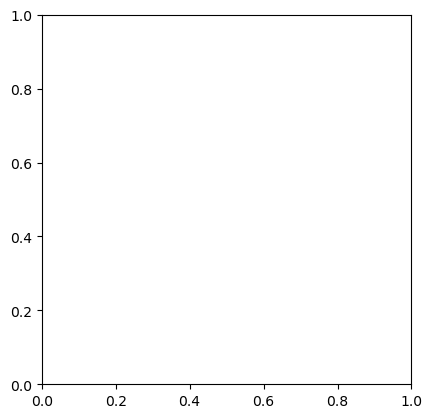

In [9]:
val_max = mvel_map.max()
val_min = mvel_map.min()
print('max = '+ str(val_max) + 'min = ' + str(val_min))

if (val_max >= abs(val_min)):
    lim = val_max
else:
    lim = abs(val_min)

plt.imshow(mvel_map,cmap = 'bwr',vmin = -lim, vmax = lim)     #creates a color map of data, (data set, cmap = 'desired color code')
plt.colorbar(label = 'Velocity [km/s]')  #following are just labels
plt.gca().invert_yaxis()
plt.xlabel('spaxel')
plt.ylabel('spaxel')
plt.plot(30,50, marker = 'x', color = 'k')

plt.grid(True)
plt.title(test_galaxy+r' Masked H-alpha Velocity')

In [ ]:
calc_chi2?

In [22]:
params = [vmax, alpha, rturn_kpc, checkedPA, i_angle, clean_coords[0], clean_coords[1]]
calc_chi2(params, mhalpha_vel , mhalpha_ivar, map_shape, r_convert, mask_f )


UnitConversionError: Can only apply 'subtract' function to dimensionless quantities when other argument is not a quantity (unless the latter is all zero/infinity/nan).

In [ ]:
clean_coords

In [19]:
vmax_guess = 250
alpha_guess = 1
Rturn_guess = 0.5
PA_guess = checkedPA
i_angle_guess = i_angle
center_guess = clean_coords

x0 = [vmax_guess, alpha_guess, Rturn_guess, PA_guess, i_angle_guess, center_guess[0],center_guess[1]]

args = (mhalpha_vel, mhalpha_ivar, map_shape, r_convert, mask_f)



vmax_bound = (0, 1000)
alpha_bound = (0.001,100)
Rturn_bound = (0.001,100)
PA_bound = (0,2*np.pi)

i_anglelow = np.max([0,i_angle-np.radians(15)])
i_anglehigh = np.min([np.radians(90), i_angle+np.radians(15)])
i_angle_bound = (i_anglelow, i_anglehigh)

centeri_bound = (center_guess[0]-5,center_guess[0]+5)
centerj_bound = (center_guess[1]-5,center_guess[1]+5)

bounds = np.array([vmax_bound,alpha_bound,Rturn_bound,PA_bound,i_angle_bound,centeri_bound,centerj_bound ])

In [20]:
result = minimize(
    calc_chi2,
    x0,
    args = args,
    method = 'Powell',
    bounds = bounds,
    options = {'disp': True}
    
)

Optimization terminated successfully.
         Current function value: 62022.217684
         Iterations: 9
         Function evaluations: 764


In [21]:
result

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 62022.21768435803
       x: [ 2.208e+02  9.066e-01  6.324e-01  5.553e+00  5.729e-01
            2.998e+01  3.056e+01]
     nit: 9
   direc: [[-3.488e-01 -3.029e-02 ...  1.836e-01 -1.584e-01]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 3.494e+00 -2.189e-02 ... -8.697e-02  1.156e-01]]
    nfev: 764

In [23]:
result.x

array([220.82531565,   0.90661865,   0.63239866,   5.55251079,
         0.5729096 ,  29.97778669,  30.56333515])

#fix plotting, and reassign new variable values using result.x index straight in to get_mvel_map function ie. result.x[some num]